In [1]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib widget

In [2]:
data = {"ch1": [], "ch3": []}

times = np.arange(1024)*2.5

with open("Data_received/Run_10k.dat") as file:

    # skip file header
    file.readline()
    file.readline()
    file.readline()
    file.readline()

    while True:


        # skip event header and check end of file
        if not file.readline(): break
        file.readline()

        # skip channel 1 header
        file.readline()

        ch1_vals = file.readline()
        ch1_vals = list(map(lambda x: -float(x), ch1_vals.split()))
        data["ch1"].append(np.array(ch1_vals))

        # skip channel 2 header
        file.readline()

        ch3_vals = file.readline()
        ch3_vals = list(map(lambda x: -float(x), ch3_vals.split()))
        data["ch3"].append(np.array(ch3_vals))



# Draw raw data plots for all events

In [3]:
# import os
# import gc
# import matplotlib
# import multiprocessing as mp

# plt.ioff()  # Disable interactive mode
# matplotlib.use("Agg")  # Use non-GUI backend

# # Function to generate and save a plot
# def save_plot(i):
#     fig, ax = plt.subplots(figsize=(6.4*2, 4.8))
#     ax.plot(times, data["ch3"][i])
    
#     fig.savefig(f"raw_signal_plots/Event_number_{i}")
    
#     plt.close(fig)
#     del fig, ax
#     gc.collect()



# num_workers = os.cpu_count()  # Use all available CPU cores
# with mp.Pool(processes=num_workers) as pool:
#     pool.map(save_plot, range(len(data["ch3"])))

# plt.ion()  # Re-enable interactive mode

# matplotlib.use("Qt5Agg")

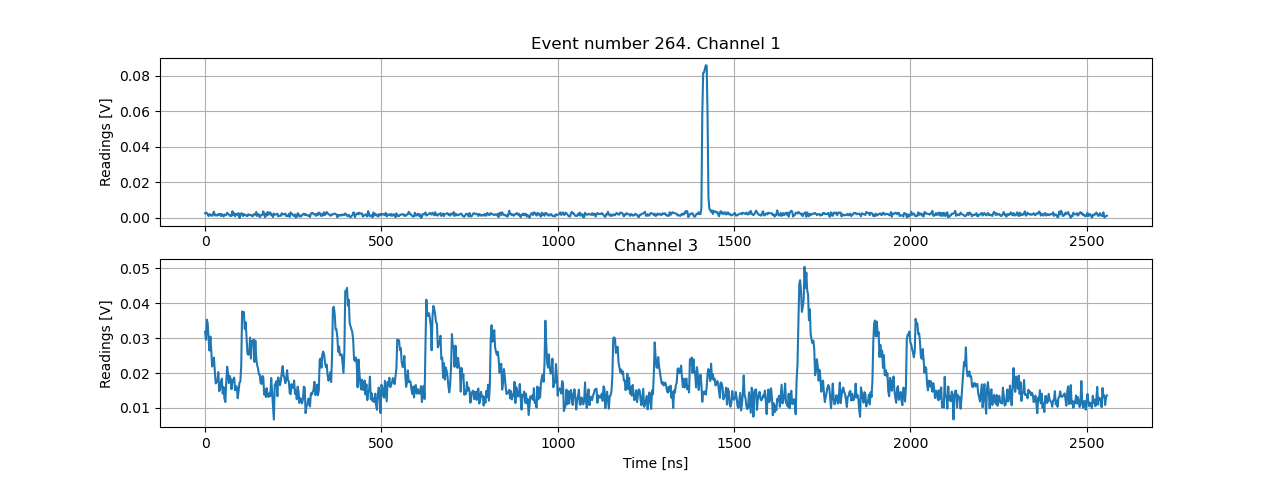

In [9]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(6.4*2, 4.8))

# ENT_NUM = 7
# ENT_NUM = 8
# ENT_NUM = 15
# ENT_NUM = 24
# ENT_NUM = 51
# ENT_NUM = 58
# ENT_NUM = 60
# ENT_NUM = 62
ENT_NUM = 264

ax1.plot(times, data["ch1"][ENT_NUM])
ax1.set_title(f"Event number {ENT_NUM}. Channel 1")
ax1.set_ylabel("Readings [V]")
ax1.grid()

ax2.plot(times, data["ch3"][ENT_NUM])
ax2.set_title("Channel 3")
ax2.set_ylabel("Readings [V]")
ax2.set_xlabel("Time [ns]")
ax2.grid()

# Testing of the fourier transition of the exponential function

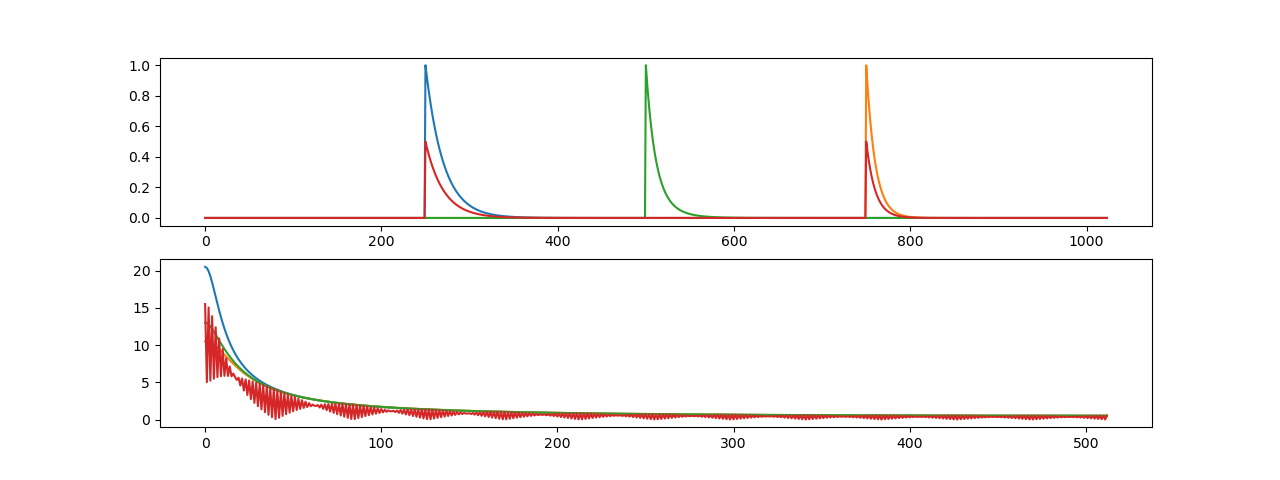

In [6]:
import numpy as np

Lambda1 = 20.0
Lambda2 = 10.0

X1 = 250
X2 = 750
X3 = 500


X  = np.arange(1024, dtype=float)

Y1 = np.zeros_like(X)
Y1[X1:] = np.exp(-(X[X1:]-X1)/Lambda1)

Y2 = np.zeros_like(X)
Y2[X2:] = np.exp(-(X[X2:]-X2)/Lambda2)

Y3 = np.zeros_like(X)
Y3[X3:] = 0.25*np.exp(-(X[X3:]-X3)/Lambda1) + 0.75*np.exp(-(X[X3:]-X3)/Lambda2)


Y4 = np.zeros_like(X)
Y4[:X2] = 0.5*Y1[:X2]
Y4[X2:] = 0.5*Y2[X2:]

fig, (ax1, ax2) = plt.subplots(2,1, figsize=(6.4*2, 4.8))

ax1.plot(Y1)
ax1.plot(Y2)
ax1.plot(Y3)
ax1.plot(Y4)

ax2.plot(np.abs(np.fft.rfft(Y1)))
ax2.plot(np.abs(np.fft.rfft(Y2)))
ax2.plot(np.abs(np.fft.rfft(Y3)))
ax2.plot(np.abs(np.fft.rfft(Y4)))

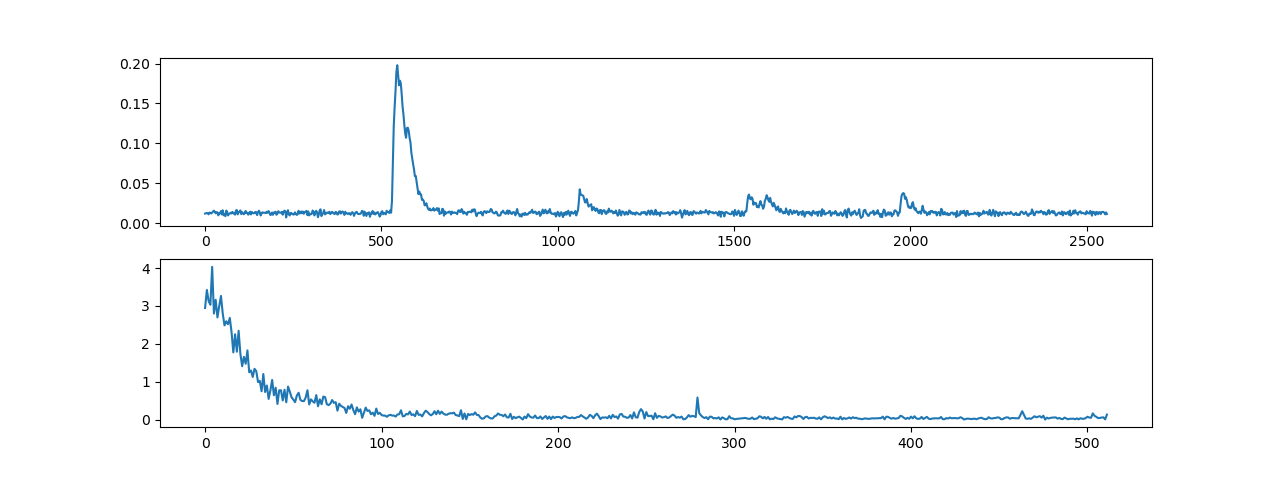

In [7]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(6.4*2, 4.8))

ev_num = 8
# ev_num = 33
# ev_num = 58

ax1.plot(times, data["ch3"][ev_num])

ax2.plot(np.abs(np.fft.rfft(data["ch3"][ev_num]))[1:])
# ax2.plot(data["ch1"][ev_num])


# Perform test fitting with one peak function

A0 = 0.013842332842707765
A1 = 0.16111131842071838
A2 = 0.021811019579758256
C4 = 3.1261580137609313e-07
L1 = 0.0308169570272846
L2 = 0.03081689246484362
a  = 522.9404910860048
b  = 550.1101744089035


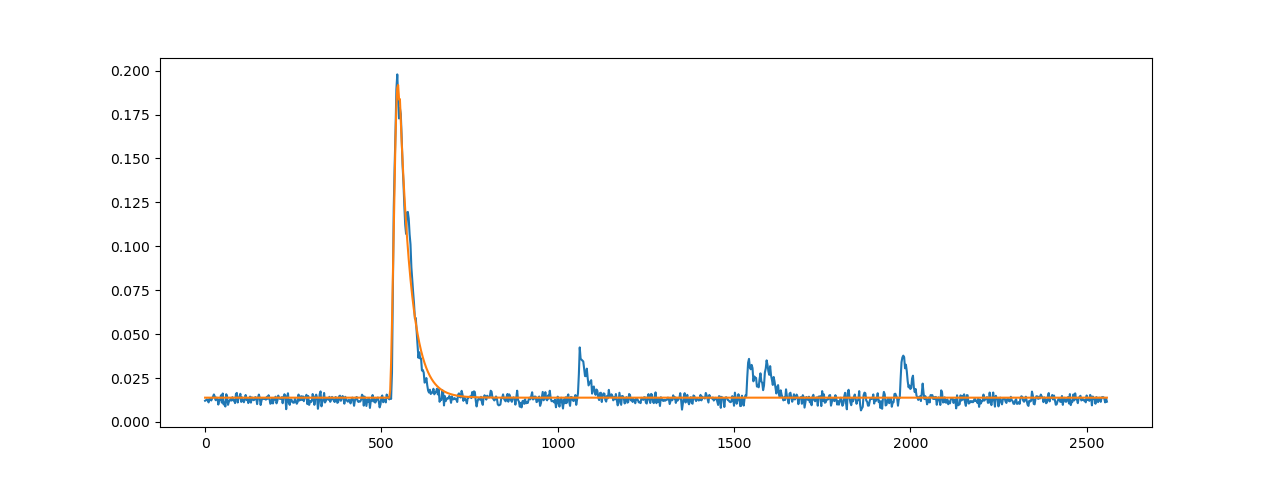

In [8]:
from scipy.optimize import curve_fit

def fitFunc(t, A0, A1, A2, C4, L1, L2, a, b):

    t_b = t-b

    D = a-b

    C0 = A1+A2
    C1 = -L1*A1-L2*A2
    C3 = C1/D**2 - 2*C4*D + 2*(C0-A0)/D**3
    C2 = (A0 - C0 - C1*D - C3*D**3 - C4*D**4)/D**2

    pol = lambda x: C0 + C1*x + C2*x**2 + C3*x**3 + C4*x**4

    results = np.ones_like(t_b)

    results[t <= a] = A0
    results[(t > a)*(t <= b)] = pol(t_b[(t > a)*(t <= b)])
    results[t > b] = A1*np.exp(-L1*t_b[t > b])+A2*np.exp(-L2*t_b[t > b]) + A0

    return results


# ev_num = 7
ev_num = 8
# ev_num = 15
# ev_num = 24
# ev_num = 51
# ev_num = 58
# ev_num = 60
# ev_num = 62

sig = data["ch3"][ev_num]
t0 = times[np.argmax(sig)]
A = np.max(sig)

L_init = 1/25.0
b_shift_from_t0 = 5
a_shift_from_t0 = 15


a = t0 - a_shift_from_t0
b = t0 + b_shift_from_t0   
A0 = np.mean(sig[times < a])
A1 = 1.0*A*np.exp(-L_init*b_shift_from_t0)
A2 = 0 # A2 = 0.3*A*np.exp(-1.3*L_init*b_shift_from_t0) 
C4 = 0
L1 = L_init
L2 = L_init

pars = [A0, A1, A2, C4, L1, L2, a, b]

bounds = (
    (     0,      0,      0, -np.inf,      0,      0,      0,      0),
    (np.inf, np.inf, np.inf,  np.inf, np.inf, np.inf, np.inf, np.inf) 
)

popt, pcov = curve_fit(fitFunc, times, sig, p0=pars, bounds=bounds)

A0, A1, A2, C4, L1, L2, a, b = popt

print("A0 =", A0)  
print("A1 =", A1)  
print("A2 =", A2)  
print("C4 =", C4)  
print("L1 =", L1)  
print("L2 =", L2)  
print("a  =", a )  
print("b  =", b )  


plt.figure(figsize=(6.4*2, 4.8))
plt.plot(times, sig)
plt.plot(times, fitFunc(times, *popt))

# Autocorelation try

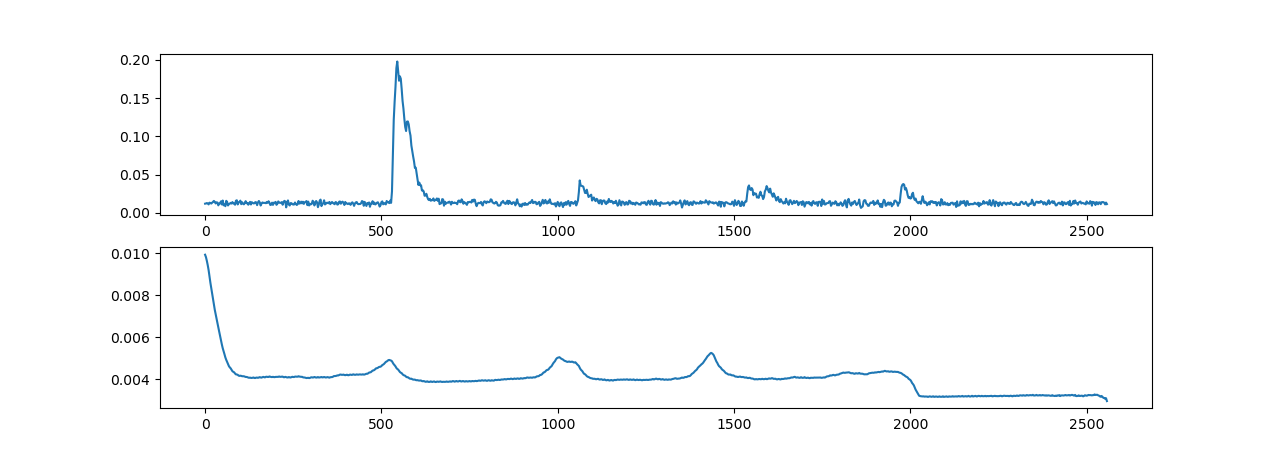

In [9]:
sig = data["ch3"][ev_num]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6.4*2, 4.6))

ax1.plot(times, sig)

autocorr = np.empty_like(times)

for i in range(times.size):

    autocorr[i] = np.sum(sig[i:]*sig[:times.size-i])/np.sum(sig[i:]+sig[:times.size-i])/2

ax2.plot(times, autocorr)

# Try laplace transformation

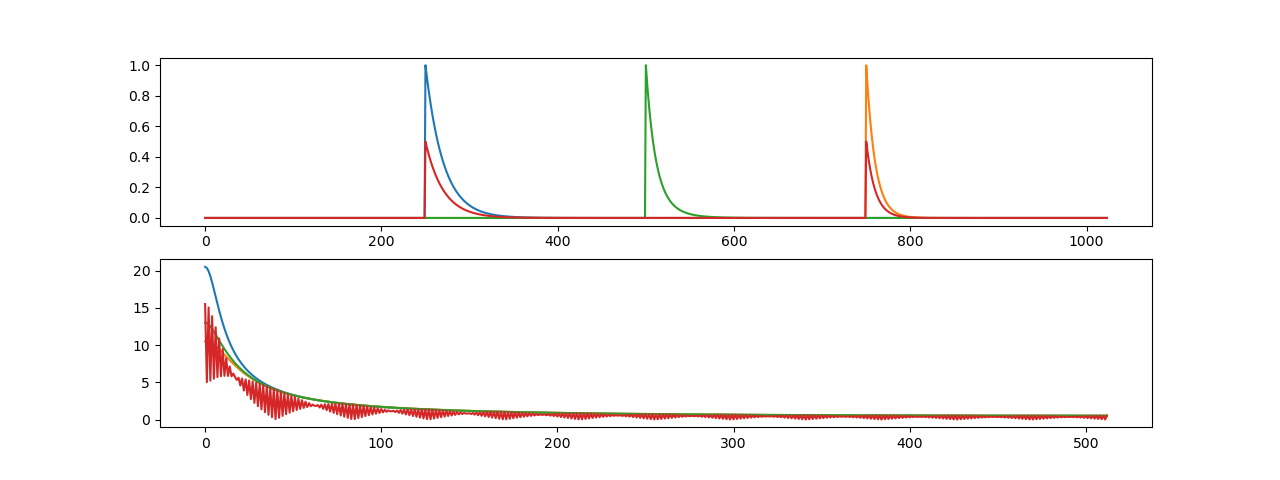

In [10]:
import numpy as np

Lambda1 = 20.0
Lambda2 = 10.0

X1 = 250
X2 = 750
X3 = 500


X  = np.arange(1024, dtype=float)

Y1 = np.zeros_like(X)
Y1[X1:] = np.exp(-(X[X1:]-X1)/Lambda1)

Y2 = np.zeros_like(X)
Y2[X2:] = np.exp(-(X[X2:]-X2)/Lambda2)

Y3 = np.zeros_like(X)
Y3[X3:] = 0.25*np.exp(-(X[X3:]-X3)/Lambda1) + 0.75*np.exp(-(X[X3:]-X3)/Lambda2)


Y4 = np.zeros_like(X)
Y4[:X2] = 0.5*Y1[:X2]
Y4[X2:] = 0.5*Y2[X2:]

fig, (ax1, ax2) = plt.subplots(2,1, figsize=(6.4*2, 4.8))

ax1.plot(Y1)
ax1.plot(Y2)
ax1.plot(Y3)
ax1.plot(Y4)

ax2.plot(np.abs(np.fft.rfft(Y1)))
ax2.plot(np.abs(np.fft.rfft(Y2)))
ax2.plot(np.abs(np.fft.rfft(Y3)))
ax2.plot(np.abs(np.fft.rfft(Y4)))

In [11]:
# size = 1024

# inxes = np.arange(size, dtype=complex)

# freq =(inxes + 0.5)/size * np.pi * 1j

# aten = np.linspace(-0.06, 0.06, size)


# freq = np.expand_dims(freq, 1)
# print(freq.shape)

# aten = np.expand_dims(aten, 0)
# print(aten.shape)

# transform_M = freq*aten

# transform_M = np.expand_dims(transform_M, 2)
# print(transform_M.shape)

# inxes = np.expand_dims(inxes, (0,1))
# print(inxes.shape)

# transform_M = transform_M*inxes

In [12]:
# print(transform_M.shape)

In [13]:
# import sys
# print(sys.getsizeof(transform_M)/1024/1024/1024)